In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
go_emotions = load_dataset("go_emotions")

print(f"Train samples: {len(go_emotions['train']):,}")
print(f"Validation samples: {len(go_emotions['validation']):,}")
print(f"Test samples: {len(go_emotions['test']):,}")

emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

print(f"\nTotal emotions: {len(emotion_labels)}")
label_to_id = {label: i for i, label in enumerate(emotion_labels)}
id_to_label = {i: label for i, label in enumerate(emotion_labels)}

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/home/sagemaker-user/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

Train samples: 43,410
Validation samples: 5,426
Test samples: 5,427

Total emotions: 28


In [3]:
train_df = pd.DataFrame(go_emotions['train'])
val_df = pd.DataFrame(go_emotions['validation'])
test_df = pd.DataFrame(go_emotions['test'])

print("Train dataset info:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print("\nFirst few samples:")
print(train_df.head(3))

Train dataset info:
Shape: (43410, 3)
Columns: ['text', 'labels', 'id']

First few samples:
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj


Text length statistics:
Train - Mean: 68.4, Max: 703
Val - Mean: 68.2, Max: 187
Test - Mean: 67.8, Max: 184


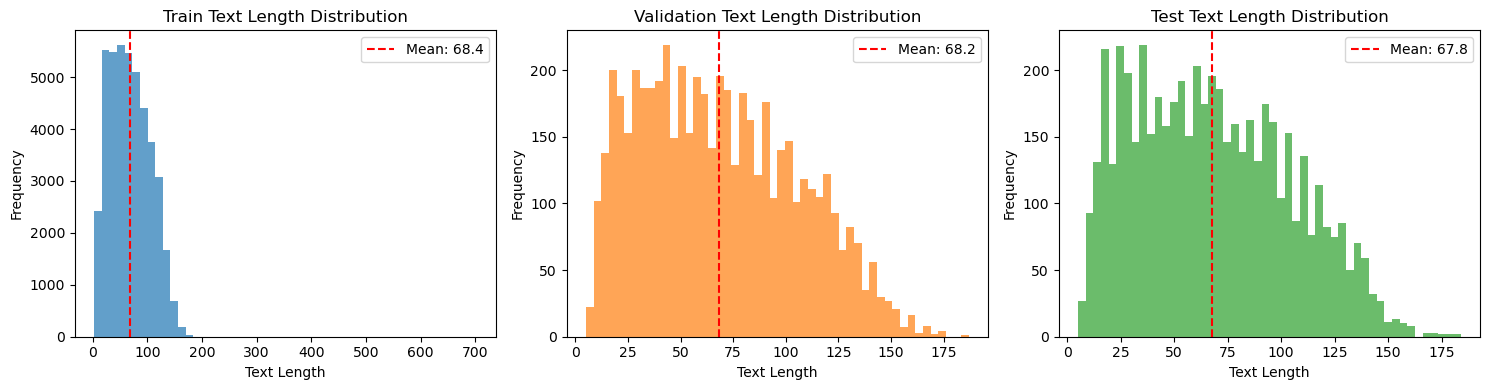

In [4]:
train_df['text_length'] = train_df['text'].str.len()
val_df['text_length'] = val_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

print("Text length statistics:")
print(f"Train - Mean: {train_df['text_length'].mean():.1f}, Max: {train_df['text_length'].max()}")
print(f"Val - Mean: {val_df['text_length'].mean():.1f}, Max: {val_df['text_length'].max()}")
print(f"Test - Mean: {test_df['text_length'].mean():.1f}, Max: {test_df['text_length'].max()}")

# Plot text length distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (df, title) in enumerate([(train_df, 'Train'), (val_df, 'Validation'), (test_df, 'Test')]):
    axes[i].hist(df['text_length'], bins=50, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'{title} Text Length Distribution')
    axes[i].set_xlabel('Text Length')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
    axes[i].legend()
plt.tight_layout()
plt.show()

In [5]:
def analyze_label_distribution(df, split_name):
    all_labels = []
    label_counts = Counter()
    
    for labels in df['labels']:
        all_labels.extend(labels)
        for label in labels:
            label_counts[emotion_labels[label]] += 1
    
    print(f"\n{split_name} Label Statistics:")
    print(f"Total label instances: {len(all_labels):,}")
    print(f"Average labels per sample: {len(all_labels)/len(df):.2f}")
    print(f"Samples with no labels: {sum(1 for labels in df['labels'] if len(labels) == 0):,}")
    
    return label_counts

In [6]:
train_label_counts = analyze_label_distribution(train_df, "Training")
val_label_counts = analyze_label_distribution(val_df, "Validation")
test_label_counts = analyze_label_distribution(test_df, "Test")


Training Label Statistics:
Total label instances: 51,103
Average labels per sample: 1.18
Samples with no labels: 0

Validation Label Statistics:
Total label instances: 6,380
Average labels per sample: 1.18
Samples with no labels: 0

Test Label Statistics:
Total label instances: 6,329
Average labels per sample: 1.17
Samples with no labels: 0


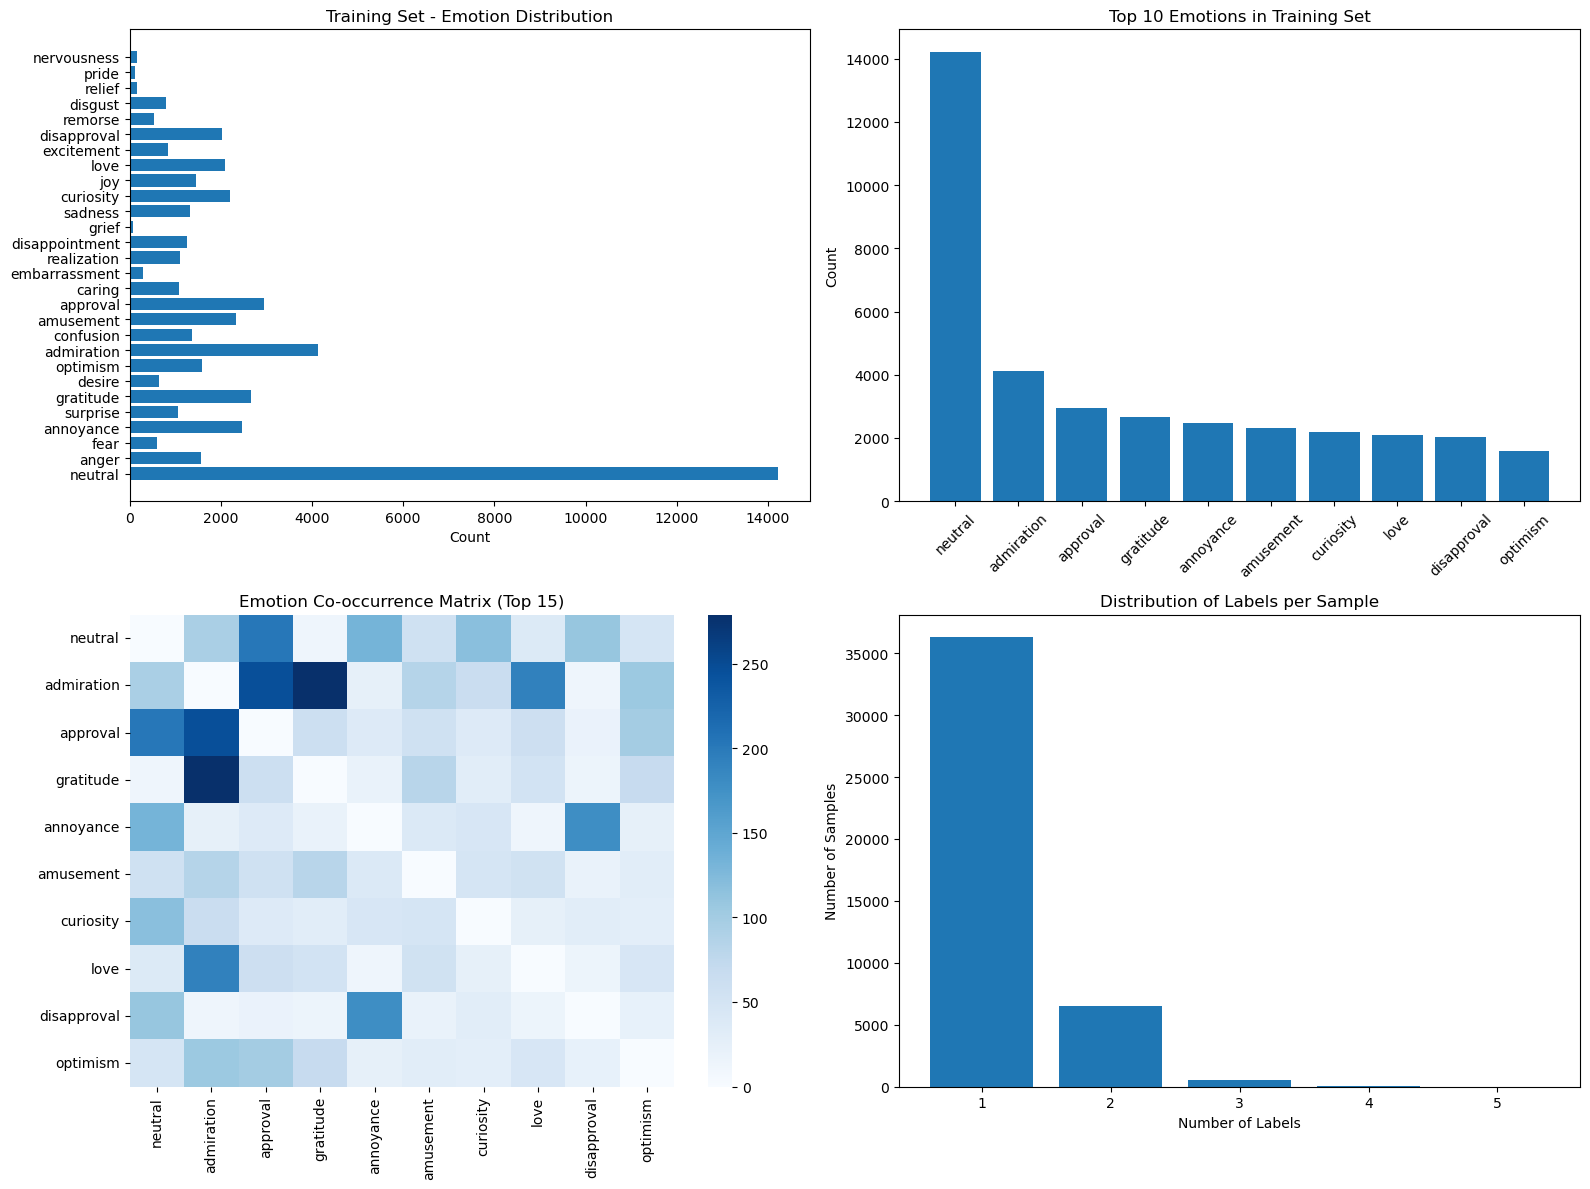

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training set distribution
emotions = list(train_label_counts.keys())
counts = list(train_label_counts.values())
axes[0,0].barh(emotions, counts)
axes[0,0].set_title('Training Set - Emotion Distribution')
axes[0,0].set_xlabel('Count')

# Top 10 emotions
top_emotions = sorted(train_label_counts.items(), key=lambda x: x[1], reverse=True)[:10]
emotions_top, counts_top = zip(*top_emotions)
axes[0,1].bar(emotions_top, counts_top)
axes[0,1].set_title('Top 10 Emotions in Training Set')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Label co-occurrence heatmap
label_matrix = np.zeros((len(emotion_labels), len(emotion_labels)))
for labels in train_df['labels']:
    for i in labels:
        for j in labels:
            if i != j:
                label_matrix[i][j] += 1

# Top 15 emotions 
top_15_indices = [label_to_id[emotion] for emotion, _ in top_emotions[:15]]
top_15_labels = [emotion for emotion, _ in top_emotions[:15]]
subset_matrix = label_matrix[np.ix_(top_15_indices, top_15_indices)]

sns.heatmap(subset_matrix, xticklabels=top_15_labels, yticklabels=top_15_labels, 
            annot=False, cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('Emotion Co-occurrence Matrix (Top 15)')

# Samples per number of labels
labels_per_sample = [len(labels) for labels in train_df['labels']]
label_count_dist = Counter(labels_per_sample)
axes[1,1].bar(label_count_dist.keys(), label_count_dist.values())
axes[1,1].set_title('Distribution of Labels per Sample')
axes[1,1].set_xlabel('Number of Labels')
axes[1,1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

In [8]:
print("Sample texts by emotion:")
for emotion in ['joy', 'anger', 'sadness', 'neutral', 'love']:
    emotion_id = label_to_id[emotion]
    samples = []
    for i, labels in enumerate(train_df['labels'][:1000]):  # Check first 1000 samples
        if emotion_id in labels:
            samples.append(train_df.iloc[i]['text'])
            if len(samples) >= 2:
                break
    
    print(f"\n{emotion.upper()}:")
    for j, sample in enumerate(samples[:2]):
        print(f"  {j+1}. {sample}")

Sample texts by emotion:

JOY:
  1. Happy to be able to help.
  2. It's because you play against 1000 ms ping EU players that have no idea what's going on. Happy hunting!

ANGER:
  1. WHY THE FUCK IS BAYLESS ISOING
  2. Fucking coward.

SADNESS:
  1. I miss them being alive
  2. Pretty sure I’ve seen this. He swings away with the harness he is wearing. Still looks painful but I think he lives

NEUTRAL:
  1. My favourite food is anything I didn't have to cook myself.
  2. Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead

LOVE:
  1. Thanks! I love watching him every week
  2. I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import sys
import logging
from datetime import datetime
from typing import Dict, List, Tuple
import json
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    hamming_loss, jaccard_score
)

In [10]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('goemotions_training.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

In [11]:
class GoEmotionsConfig:
    def __init__(self):
        self.base_model = "roberta-base"
        self.num_emotions = 28
        self.max_length = 128
        self.hidden_dropout = 0.3
        
        self.batch_size = 32
        self.learning_rate = 2e-5
        self.num_epochs = 5
        self.warmup_steps = 1000
        self.weight_decay = 0.01
        self.gradient_clip = 1.0
        
        self.threshold = 0.5
        self.class_weights = None
        
        # Paths
        self.model_save_path = "./models/goemotions_roberta"
        self.results_path = "./results/goemotions"
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = 4 if torch.cuda.is_available() else 0
        
        os.makedirs(self.model_save_path, exist_ok=True)
        os.makedirs(self.results_path, exist_ok=True)

config = GoEmotionsConfig()
print(f"Using device: {config.device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
CUDA available: True
GPU: Tesla T4


In [12]:
class GoEmotionsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[List[int]], tokenizer, max_length: int = 128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Create multi-label tensor
        label_tensor = torch.zeros(28)
        for label in self.labels[idx]:
            label_tensor[label] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_tensor
        }


In [13]:
class GoEmotionsModel(nn.Module):
    def __init__(self, config: GoEmotionsConfig):
        super(GoEmotionsModel, self).__init__()
        self.config = config
        self.roberta = AutoModel.from_pretrained(config.base_model)
        
        hidden_size = self.roberta.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size // 2, config.num_emotions)
        )
        
        self.dropout = nn.Dropout(config.hidden_dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        self._init_weights()

    def _init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        mean_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean pooling
        
        combined = cls_output + mean_output
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)
        
        logits = self.classifier(combined)
        return logits

In [14]:
class GoEmotionsTrainer:
    def __init__(self, config: GoEmotionsConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)
        self.emotion_labels = emotion_labels
        self.label_to_id = label_to_id
        self.id_to_label = id_to_label
        
        self.tokenizer = None
        self.model = None
        self.optimizer = None
        self.scheduler = None
        
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1_macro': [],
            'val_f1_micro': []
        }

    def load_dataset(self) -> Tuple[Dataset, Dataset, Dataset]:
        self.logger.info("Processing GoEmotions dataset...")
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.base_model)
        
        train_texts, train_labels = self._process_dataset_split(go_emotions['train'])
        val_texts, val_labels = self._process_dataset_split(go_emotions['validation'])
        test_texts, test_labels = self._process_dataset_split(go_emotions['test'])
        
        self._calculate_class_weights(train_labels)
        
        train_dataset = GoEmotionsDataset(train_texts, train_labels, self.tokenizer, self.config.max_length)
        val_dataset = GoEmotionsDataset(val_texts, val_labels, self.tokenizer, self.config.max_length)
        test_dataset = GoEmotionsDataset(test_texts, test_labels, self.tokenizer, self.config.max_length)
        
        return train_dataset, val_dataset, test_dataset

    def _process_dataset_split(self, split) -> Tuple[List[str], List[List[int]]]:
        texts = []
        labels = []
        for example in split:
            texts.append(example['text'])
            labels.append(example['labels'])
        self.logger.info(f"Processed {len(texts)} examples")
        return texts, labels

    def _calculate_class_weights(self, train_labels: List[List[int]]):
        label_counts = np.zeros(self.config.num_emotions)
        total_samples = len(train_labels)
        
        for label_list in train_labels:
            for label in label_list:
                label_counts[label] += 1
        
        weights = total_samples / (self.config.num_emotions * label_counts + 1e-6)
        self.config.class_weights = torch.FloatTensor(weights).to(self.config.device)
        self.logger.info("Class weights calculated")

    def initialize_model(self):
        self.model = GoEmotionsModel(self.config).to(self.config.device)
        
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        self.logger.info(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}")
        
        self.optimizer = AdamW(
            self.model.parameters(), 
            lr=self.config.learning_rate, 
            weight_decay=self.config.weight_decay
        )

    def create_scheduler(self, train_dataloader):
        total_steps = len(train_dataloader) * self.config.num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer, 
            num_warmup_steps=self.config.warmup_steps, 
            num_training_steps=total_steps
        )

    def train_epoch(self, train_dataloader) -> float:
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(train_dataloader, desc="Training"):
            input_ids = batch['input_ids'].to(self.config.device)
            attention_mask = batch['attention_mask'].to(self.config.device)
            labels = batch['labels'].to(self.config.device)

            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            
            # Use class weights if available
            loss_fn = nn.BCEWithLogitsLoss(
                pos_weight=self.config.class_weights if self.config.class_weights is not None else None
            )
            loss = loss_fn(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
        
        return total_loss / len(train_dataloader)

    def evaluate(self, val_dataloader) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)

                logits = self.model(input_ids, attention_mask)
                loss_fn = nn.BCEWithLogitsLoss()
                loss = loss_fn(logits, labels)
                total_loss += loss.item()

                predictions = torch.sigmoid(logits) > self.config.threshold
                all_predictions.append(predictions.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)

        accuracy = accuracy_score(all_labels, all_predictions)
        hamming = hamming_loss(all_labels, all_predictions)
        jaccard = jaccard_score(all_labels, all_predictions, average='samples', zero_division=0)
        
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='macro', zero_division=0
        )
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='micro', zero_division=0
        )

        metrics = {
            'accuracy': accuracy,
            'hamming_loss': hamming,
            'jaccard_score': jaccard,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'f1_micro': f1_micro,
            'loss': total_loss / len(val_dataloader)
        }
        return metrics

    def train(self, train_dataset: Dataset, val_dataset: Dataset):
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=True, 
            num_workers=self.config.num_workers
        )
        val_dataloader = DataLoader(
            val_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=False, 
            num_workers=self.config.num_workers
        )
        
        self.initialize_model()
        self.create_scheduler(train_dataloader)

        best_f1 = 0.0
        for epoch in range(self.config.num_epochs):
            self.logger.info(f"Epoch {epoch+1}/{self.config.num_epochs}")
            
            train_loss = self.train_epoch(train_dataloader)
            val_metrics = self.evaluate(val_dataloader)
            
            self.logger.info(
                f"Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_metrics['loss']:.4f}, "
                f"Val F1 Macro: {val_metrics['f1_macro']:.4f}"
            )

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['val_f1_macro'].append(val_metrics['f1_macro'])
            self.history['val_f1_micro'].append(val_metrics['f1_micro'])

            # Save best model
            if val_metrics['f1_macro'] > best_f1:
                best_f1 = val_metrics['f1_macro']
                self.save_model('best_model.pt')
                self.logger.info(f"Saved new best model with F1 Macro: {best_f1:.4f}")

        # Save final model
        self.save_model('final_model.pt')
        
        # Save training history
        with open(os.path.join(self.config.results_path, 'training_history.json'), 'w') as f:
            json.dump(self.history, f, indent=2)
        
        self.logger.info("Training completed")

    def save_model(self, filename: str):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config.__dict__,
            'emotion_labels': self.emotion_labels,
            'label_to_id': self.label_to_id,
            'id_to_label': self.id_to_label
        }
        filepath = os.path.join(self.config.model_save_path, filename)
        torch.save(checkpoint, filepath)
        self.tokenizer.save_pretrained(self.config.model_save_path)

    def test(self, test_dataset: Dataset) -> Dict[str, float]:
        test_dataloader = DataLoader(
            test_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=False, 
            num_workers=self.config.num_workers
        )
        metrics = self.evaluate(test_dataloader)
        self.logger.info(f"Test Metrics: {metrics}")
        
        with open(os.path.join(self.config.results_path, 'test_results.json'), 'w') as f:
            json.dump(metrics, f, indent=2)
        return metrics

    def predict(self, texts: List[str], threshold: float = None) -> List[Dict[str, float]]:
        if threshold is None:
            threshold = self.config.threshold
        
        self.model.eval()
        results = []
        
        with torch.no_grad():
            for text in texts:
                encoding = self.tokenizer(
                    text, 
                    truncation=True, 
                    padding='max_length', 
                    max_length=self.config.max_length, 
                    return_tensors='pt'
                ).to(self.config.device)
                
                logits = self.model(**encoding)
                probabilities = torch.sigmoid(logits).cpu().numpy()[0]
                predictions = {self.id_to_label[i]: float(prob) for i, prob in enumerate(probabilities)}
                results.append(predictions)
        
        return results

    def plot_training_history(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(self.history['val_accuracy'], color='green')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(self.history['val_f1_macro'], label='F1 Macro', color='purple')
        axes[1, 0].plot(self.history['val_f1_micro'], label='F1 Micro', color='orange')
        axes[1, 0].set_title('Validation F1 Scores')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        fig.delaxes(axes[1, 1])
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.results_path, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()


In [15]:
trainer = GoEmotionsTrainer(config)


In [16]:
train_dataset, val_dataset, test_dataset = trainer.load_dataset()
print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


2025-09-03 18:06:33,018 - INFO - Processing GoEmotions dataset...
2025-09-03 18:06:36,198 - INFO - Processed 43410 examples
2025-09-03 18:06:36,463 - INFO - Processed 5426 examples
2025-09-03 18:06:36,725 - INFO - Processed 5427 examples
2025-09-03 18:06:37,000 - INFO - Class weights calculated
Dataset sizes - Train: 43410, Val: 5426, Test: 5427


In [17]:
print("Starting training")
trainer.train(train_dataset, val_dataset)

Starting training


2025-09-03 18:06:46.674980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 18:06:46.690997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756922806.709252    1246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756922806.715302    1246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 18:06:46.733337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2025-09-03 18:06:51,801 - INFO - Model parameters: total=125,543,836, trainable=125,543,836
2025-09-03 18:06:51,802 - INFO - Epoch 1/5


Evaluating: 100%|██████████| 170/170 [00:29<00:00,  5.82it/s]


2025-09-03 18:21:20,600 - INFO - Train Loss: 0.2242, Val Loss: 0.1257, Val F1 Macro: 0.3369
2025-09-03 18:21:22,336 - INFO - Saved new best model with F1 Macro: 0.3369
2025-09-03 18:21:22,337 - INFO - Epoch 2/5


Evaluating: 100%|██████████| 170/170 [00:29<00:00,  5.82it/s]


2025-09-03 18:35:53,913 - INFO - Train Loss: 0.1107, Val Loss: 0.1069, Val F1 Macro: 0.4324
2025-09-03 18:35:55,724 - INFO - Saved new best model with F1 Macro: 0.4324
2025-09-03 18:35:55,724 - INFO - Epoch 3/5


Evaluating: 100%|██████████| 170/170 [00:29<00:00,  5.82it/s]


2025-09-03 18:50:27,325 - INFO - Train Loss: 0.0936, Val Loss: 0.1033, Val F1 Macro: 0.4753
2025-09-03 18:50:29,124 - INFO - Saved new best model with F1 Macro: 0.4753
2025-09-03 18:50:29,125 - INFO - Epoch 4/5


Evaluating: 100%|██████████| 170/170 [00:29<00:00,  5.81it/s]


2025-09-03 19:05:00,835 - INFO - Train Loss: 0.0844, Val Loss: 0.1009, Val F1 Macro: 0.4825
2025-09-03 19:05:02,662 - INFO - Saved new best model with F1 Macro: 0.4825
2025-09-03 19:05:02,663 - INFO - Epoch 5/5


Evaluating: 100%|██████████| 170/170 [00:29<00:00,  5.82it/s]


2025-09-03 19:19:34,394 - INFO - Train Loss: 0.0781, Val Loss: 0.1007, Val F1 Macro: 0.4943
2025-09-03 19:19:36,187 - INFO - Saved new best model with F1 Macro: 0.4943
2025-09-03 19:19:54,644 - INFO - Training completed


In [18]:
print("Evaluating on test set")
test_metrics = trainer.test(test_dataset)

print(f"\nFinal Test Results:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 Macro: {test_metrics['f1_macro']:.4f}")
print(f"F1 Micro: {test_metrics['f1_micro']:.4f}")
print(f"Jaccard Score: {test_metrics['jaccard_score']:.4f}")
print(f"Hamming Loss: {test_metrics['hamming_loss']:.4f}")


Evaluating on test set


Evaluating: 100%|██████████| 170/170 [00:28<00:00,  5.88it/s]


2025-09-03 19:20:23,637 - INFO - Test Metrics: {'accuracy': 0.3384927215772987, 'hamming_loss': 0.03441785780094238, 'jaccard_score': 0.39077759351391195, 'precision_macro': 0.5536551214724618, 'recall_macro': 0.5144175831204292, 'f1_macro': 0.4918873008298034, 'precision_micro': 0.6423944026949987, 'recall_micro': 0.39168905040290725, 'f1_micro': 0.48665096191597956, 'loss': 0.10017517489545485}

Final Test Results:
Accuracy: 0.3385
F1 Macro: 0.4919
F1 Micro: 0.4867
Jaccard Score: 0.3908
Hamming Loss: 0.0344


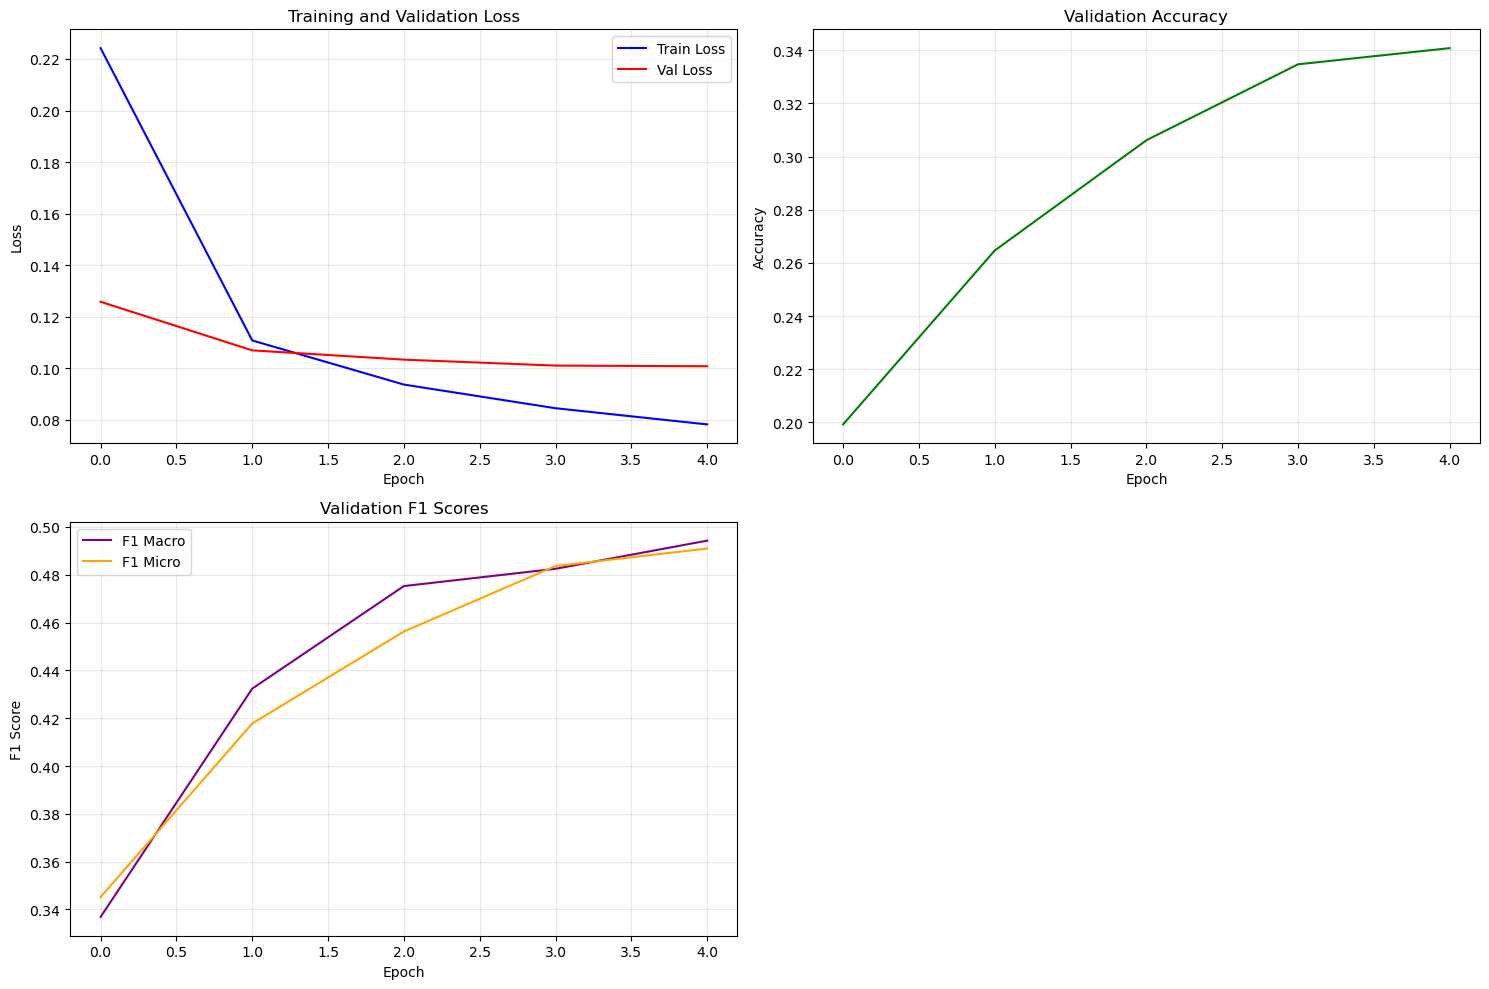

In [19]:
trainer.plot_training_history()


In [20]:
sample_texts = [
    "I love this so much!",
    "This makes me really angry and frustrated",
    "I'm feeling quite sad about this situation",
    "I'm so excited and grateful for this opportunity!",
    "This is confusing and I don't understand",
    "I'm worried about the future",
    "That was absolutely hilarious",
    "I feel proud of what I accomplished"
]

print("Sample predictions:")
predictions = trainer.predict(sample_texts)
for text, pred in zip(sample_texts, predictions):
    # Get top 3 emotions above threshold
    top_emotions = sorted(pred.items(), key=lambda x: x[1], reverse=True)
    relevant_emotions = [(emotion, score) for emotion, score in top_emotions if score > 0.1][:3]
    
    print(f"\nText: '{text}'")
    for emotion, score in relevant_emotions:
        print(f"  {emotion}: {score:.3f}")



Sample predictions:

Text: 'I love this so much!'
  love: 0.988

Text: 'This makes me really angry and frustrated'
  anger: 0.906
  annoyance: 0.164

Text: 'I'm feeling quite sad about this situation'
  sadness: 0.978

Text: 'I'm so excited and grateful for this opportunity!'
  excitement: 0.969
  gratitude: 0.123

Text: 'This is confusing and I don't understand'
  confusion: 0.957

Text: 'I'm worried about the future'
  nervousness: 0.995
  fear: 0.769

Text: 'That was absolutely hilarious'
  amusement: 0.975

Text: 'I feel proud of what I accomplished'
  pride: 0.995
  admiration: 0.183


In [22]:
results_summary = {
    'test_metrics': test_metrics,
    'per_emotion_metrics': emotion_metrics,
    'config': config.__dict__,
    'training_completed': datetime.now().isoformat()
}

with open(os.path.join(config.results_path, 'final_results.json'), 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"\nTraining completed! Results saved to: {config.results_path}")
print("Model ready for fine-tuning on TweetEval dataset.")


Training completed! Results saved to: ./results/goemotions
Model ready for fine-tuning on TweetEval dataset.
